In [2]:
import numpy as np
import xarray as xr
import cv2 as cv
import os
import pandas as pd
import gdown
import src.Utils as utils
from zipfile import ZipFile 

# Building of mini datacubes and preprocessing

Full execution of this notebook on our server takes about 10mins

This notebook focuses on three objectives :
* The construction of a set of mini datacubes. Each mini datacube is a subset of the full resolution data aligned with each spatial ERA5 pixel (tile of about 31 sqkm)
* Some data preprocessing : missing values imputation and filtering of out of france data. **The model will only be evaluated on french data**
* Creation of two new static features (distance to surface_water and distance to sea)

#### Creation of the paths 
If you modify *save_path* make sure to modify it accordingly in the *Baseline_model_01* notebook and *Baseline_model_02* notebook


In [5]:
save_path = "localdata"
isExist = os.path.exists(save_path)
if not isExist:
    os.makedirs(save_path)
isExist = os.path.exists(save_path+"/smallbox/label/")
if not isExist:
    os.makedirs(save_path+"/smallbox/label/")
isExist = os.path.exists(save_path+"/smallbox/static/")
if not isExist:
    os.makedirs(save_path+"/smallbox/static/")

In [5]:
import requests
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [6]:
file_id = '1Sg1BL18GpRjN-SX6a65y9llv8mWBktW5'
destination = save_path+'/training_data.zip' 
download_file_from_google_drive(file_id, destination)

#### Training data download

In [47]:
url = 'https://drive.usercontent.google.com/download?id=1Sg1BL18GpRjN-SX6a65y9llv8mWBktW5&confirm=t'
output = save_path+'/training_data.zip' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.usercontent.google.com/download?id=1Sg1BL18GpRjN-SX6a65y9llv8mWBktW5&confirm=t
To: /home/flood/dme/1202/Flood_Prediction_starting_kit/localdata/training_data.zip
100%|██████████| 941M/941M [00:16<00:00, 57.7MB/s] 


'localdata/training_data.zip'

In [48]:
with ZipFile("localdata/training_data.zip", 'r') as zObject: 
    zObject.extractall( 
        path="localdata/raw/") 

#### Data loading

In [21]:
ERA5 = xr.open_dataset( save_path+'/raw/ERA5_train.nc') #Dynamic data at the 0.25 degree / ERA5 resolution
static = xr.open_dataset(save_path+"/raw/static_train.nc") #Dynamic data at the 0.25 degree / ERA5 resolution
final_label_ERA5 = xr.open_dataset(save_path+"/raw/final_label_ERA5_train.nc") #Dynamic data at the 0.25 degree / ERA5 resolution
final_label = xr.open_dataset(save_path+"/raw/final_label_train.nc") #Dynamic data at the 0.25 degree / ERA5 resolution
relevent_data_tag_binary_mask = xr.open_dataset(save_path+"/raw/relevent_data_tag_binary_mask.nc") # Mapping of permanent water and out of france data


ERA5_train dataset contains two spatiotemporal features, computated dayly from 2000-01-01 up to 2004-01-01 at the 0.25 degree / ERA5 resolution

In [ ]:
ERA5

<xarray.Dataset>
Dimensions:    (time: 1462, latitude: 45, longitude: 57)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2004-01-01
  * longitude  (longitude) float64 -5.0 -4.75 -4.5 -4.25 ... 8.25 8.5 8.75 9.0
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 41.5 41.25 41.0
Data variables:
    tp         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    description:  Precipitation, temperature and soil related data.

Static dataset contains 13 spatial static features at the 250m / Full resolution

In [8]:
static

<xarray.Dataset>
Dimensions:                        (x: 5953, y: 3936, band: 13)
Coordinates:
  * x                              (x) float64 -5.139 -5.137 ... 8.227 8.229
  * y                              (y) float64 51.09 51.09 51.08 ... 42.25 42.25
    variable                       object ...
  * band                           (band) object 'soilgrid_bdod' ... 'topolog...
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float64 ...
    spatial_ref                    int32 ...

final_label_ERA5_train contains floods events at the ERA5 resolution.
1 indicate sptial are where flood occured, 0 indicate spatial are without flood, nan indicates permanent water and out of france data. 
Warning : time dimension is define by the starting day of the flood and the ending day of the flood, days without floods are not in the dataset.

In [9]:
final_label_ERA5

<xarray.Dataset>
Dimensions:                        (x: 57, y: 45, band: 10)
Coordinates:
  * x                              (x) float64 -5.0 -4.75 -4.5 ... 8.5 8.75 9.0
  * y                              (y) float64 52.0 51.75 51.5 ... 41.25 41.0
  * band                           (band) object '20021213-20021214' ... '200...
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 ...
    spatial_ref                    int32 ...

## Full resolution Data Processing

#### Conversion to float32

To reduce computational cost.

In [22]:
static['__xarray_dataarray_variable__'].values = static['__xarray_dataarray_variable__'].values.astype('float32')


#### Distance to sea feature computation

Creation of *dist_sea* (distance to sea) feature from land sea limit.

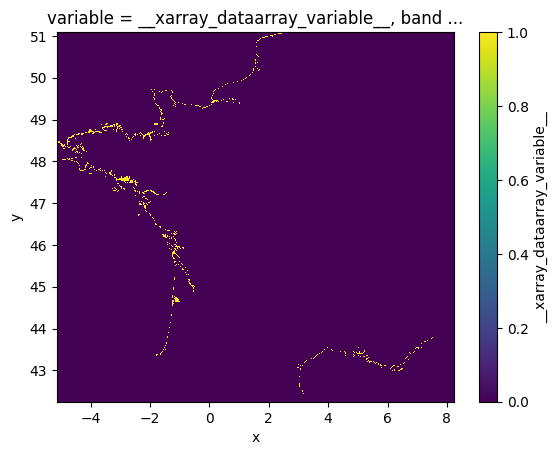

In [23]:
static.sel(band="land_sea_limit").__xarray_dataarray_variable__.plot()

In [24]:
sea_limit = static["__xarray_dataarray_variable__"].sel(band="land_sea_limit")

surface_waters_mask = sea_limit < 1

surface_waters_mask_uint8 = surface_waters_mask.astype('uint8') * 255
distance_to_sea = cv.distanceTransform(surface_waters_mask_uint8.values, cv.DIST_L2, cv.DIST_MASK_PRECISE)

distance_to_sea_da = xr.DataArray(distance_to_sea,
                                    dims=['y', 'x'],  
                                    coords={'y': static.coords['y'], 'x': static.coords['x']})

distance_to_sea_da = distance_to_sea_da.expand_dims({'band': ['dist_sea']})


combined_data = xr.concat([static['__xarray_dataarray_variable__'], distance_to_sea_da], dim='band')

static_with_dts = xr.Dataset({'__xarray_dataarray_variable__': combined_data})

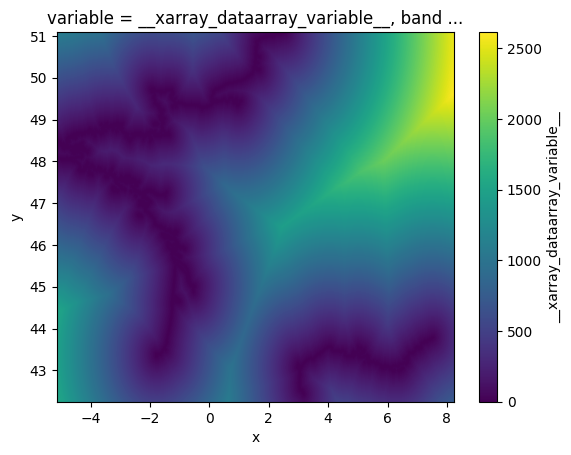

In [25]:
static_with_dts["__xarray_dataarray_variable__"].sel(band="dist_sea").plot()

#### Distance to surface_water feature computation

Creation of *dist_water* (distance to surface_water) feature from water density (water density doesn't  includes only surface_waters but also any type of watercourse and lake).

In [26]:
temp = static_with_dts["__xarray_dataarray_variable__"].sel(band="water_density")
surface_waters_mask = temp < 25 # 25 is the threshold for water density, we compute water distance to  wit

surface_waters_mask_uint8 = surface_waters_mask.astype('uint8') * 255
distance_to_surface_water = cv.distanceTransform(surface_waters_mask_uint8.values, cv.DIST_L2, cv.DIST_MASK_PRECISE)

distance_to_surface_water_da = xr.DataArray(distance_to_surface_water,
                                    dims=['y', 'x'],  
                                    coords={'y': static_with_dts.coords['y'], 'x': static_with_dts.coords['x']})

distance_to_surface_water_da = distance_to_surface_water_da.expand_dims({'band': ['dist_water']})


combined_data = xr.concat([static_with_dts['__xarray_dataarray_variable__'], distance_to_surface_water_da], dim='band')

static_with_dts_dtr = xr.Dataset({'__xarray_dataarray_variable__': combined_data})


#### Filtering

Label is set to -1 for data outside of France (using "bassin_versants_cdbh" data for filtering). The model will only be evaluated on France teritory data.


In [27]:
final_label

<xarray.Dataset>
Dimensions:                        (x: 5953, y: 3936, time: 33)
Coordinates:
  * x                              (x) float64 -5.139 -5.137 ... 8.227 8.229
  * y                              (y) float64 51.09 51.09 51.08 ... 42.25 42.25
  * time                           (time) datetime64[ns] 2002-08-04 ... 2003-...
    spatial_ref                    int32 ...
Data variables:
    __xarray_dataarray_variable__  (time, y, x) float64 ...

In [28]:

bassin_versants_cdbh_band = static_with_dts_dtr["__xarray_dataarray_variable__"].sel(band="watershed")

nan_mask = bassin_versants_cdbh_band == 0
data_array = final_label["__xarray_dataarray_variable__"]

for time in final_label.time.values:
    time_slice = data_array.sel(time=time)
    time_slice = time_slice.where(~nan_mask, -1)    
    data_array.loc[dict(time=time)] = time_slice

data_array = data_array.fillna(-1)
final_label["__xarray_dataarray_variable__"] = data_array



#### Saving of the labels

In [29]:
final_label.to_netcdf(f'{save_path}/final_label_Full_Rez.nc', engine='h5netcdf')


#### Missing data imputation

We use mean imputation as a naive imputation strategy for the baseline model. Other methods can be used.

In [30]:
data_array = static_with_dts_dtr["__xarray_dataarray_variable__"]

band_means = data_array.mean(dim=['x', 'y'], skipna=True)

for band in static_with_dts_dtr.band.values:  
    band_mean = band_means.sel(band=band).item()
    updated_band = data_array.sel(band=band).fillna(band_mean)
    data_array.loc[dict(band=band)] = updated_band

static_with_dts_dtr["__xarray_dataarray_variable__"] = data_array



#### Removal of land_sea_limit

Land_sea_limit is used to comptute *dist_sea* feature but does not seems in itself a useful feature, we choose to remove it from the training data set.

In [31]:
all_bands = static_with_dts_dtr.coords['band'].values

bands_except_dist_water = [band for band in all_bands if band != "land_sea_limit"]

selected_bands = static_with_dts_dtr.sel(band=bands_except_dist_water)


#### Saving of Full Rez static data

In [32]:
encoding = {'__xarray_dataarray_variable__': {'dtype': 'float32'}}
selected_bands.to_netcdf(f'{save_path}/static_Full_Rez.nc', encoding=encoding, engine='h5netcdf')

In [33]:
processed_static = xr.open_dataset(f'{save_path}/static_Full_Rez.nc')

## ERA5 Resolution Data processing

To train the first model, we need to chunk the geospatial data and the labels at the ERA5 spatial resolution. The chunked labels for flood maps are already provided, we just need to create the complete label set over the time period.


**Creation of the static data at the ERA5 spatial resolution.**

In [34]:
def compute_averages(big_ds, small_ds):
    averaged_values = {}

    for band in big_ds.band.values:
        band_averaged_values = np.zeros((len(small_ds.y), len(small_ds.x)), dtype=np.float32)

        for i, y in enumerate(small_ds.y.values):
            for j, x in enumerate(small_ds.x.values):
                corresponding_pixels = big_ds.sel(x=x, y=y, method="nearest").sel(band=band).__xarray_dataarray_variable__.values
                band_averaged_values[i, j] = np.nanmean(corresponding_pixels)  

        averaged_values[str(band)] = band_averaged_values

    return averaged_values

averaged_data_static = compute_averages(selected_bands, final_label_ERA5)

In [35]:
static_ERA5_output = xr.Dataset(
    {band: (["y", "x"], averaged_data_static[band]) for band in averaged_data_static},
    coords={
        "x": final_label_ERA5.x.values,
        "y": final_label_ERA5.y.values
    }
)



Saving Geospatial data at EAR5 resolution

In [36]:
static_ERA5_output.to_netcdf(f'{save_path}/static_ERA5.nc', engine='h5netcdf')

### Creation of the ERA5 resolution labels from flood maps 

Filtering of out of France data on the ERA5 resolution label, we use watershed feature to remove data outside of france from the label.

In [37]:
watershed_band = averaged_data_static["watershed"]

nan_mask = watershed_band == 0
data_array = final_label_ERA5["__xarray_dataarray_variable__"]

for time in final_label_ERA5.band.values:
    time_slice = data_array.sel(band=time)
    time_slice = time_slice.where(~nan_mask, -1)    
    data_array.loc[dict(band=time)] = time_slice

final_label_ERA5["__xarray_dataarray_variable__"] = data_array

Spread the flood maps over the standardise weekly time dimension and add empty maps for non flooded weeks.

In [38]:
raw_labels = final_label_ERA5.where(final_label_ERA5.band != '20030101-200301080000000000-0000014848', drop=True)
# renanming of the duplicated band/date
band_series = pd.Series(raw_labels.band.values)
band_series = band_series.replace({'20030101-200301080000000000-0000000000': '20030101-20030108'})
raw_labels = raw_labels.assign_coords(band=band_series.values)

# convert the band/date to datetime64
original_band_dates = [utils.parse_dates(band) for band in raw_labels.band.values]

# filter the bands/dates to keep only the ones between start_date and end_date
start_date = pd.to_datetime("2002-08-03")
end_date = pd.to_datetime("2004-01-01")

# addition of the missing bands/dates (weeks without flood)
new_bands = pd.date_range(start=start_date, end=end_date, freq='W').values        
new_data = np.full((len(new_bands), *raw_labels.__xarray_dataarray_variable__.shape[1:]), np.nan)
#filling the new_data with the original data (with flood)
outside_of_france_mask = raw_labels['__xarray_dataarray_variable__'][0]==-1

for i, new_band in enumerate(new_bands):
    new_data[i][outside_of_france_mask] = -1
    for old_start, old_end in original_band_dates:
        if (new_band >= np.datetime64(old_start)) and (new_band <= np.datetime64(old_end)):
            old_band_index = np.where(raw_labels.band == f'{old_start.strftime("%Y%m%d")}-{old_end.strftime("%Y%m%d")}')[0][0]
            new_data[i] = raw_labels.__xarray_dataarray_variable__[old_band_index].values
        elif (new_band <= np.datetime64(old_end)) and (new_band >= (np.datetime64(old_start)- np.timedelta64(7,'D'))):
            old_band_index = np.where(raw_labels.band == f'{old_start.strftime("%Y%m%d")}-{old_end.strftime("%Y%m%d")}')[0][0]
            new_data[i] = raw_labels.__xarray_dataarray_variable__[old_band_index].values


new_da = xr.DataArray(new_data, coords=[new_bands, raw_labels.y, raw_labels.x], dims=["band", "y", "x"])

final_label_ERA5_processed = xr.Dataset({
    '__xarray_dataarray_variable__': new_da
    }, coords={
    'band': new_bands,
    'x': raw_labels.x,
    'y': raw_labels.y
    }) # the new label xarray dataset

final_label_ERA5_processed = final_label_ERA5_processed.rename({'band': 'time'})


In [39]:
final_label_ERA5_processed.to_netcdf(f'{save_path}/final_label_Full_ERA5.nc', engine='h5netcdf')

## Mini datacubes data processing
* The resolution is the same as the full resolution 
* Each data cube bounding box correspond to one point at ERA5 resolution

In [40]:
for latitude in ERA5.latitude.values:
    for longitude in ERA5.longitude.values:
        bbox=(longitude-.125, latitude-.125, longitude+.125, latitude+.125)
        if(bbox[2]>min(final_label.x.values)) & (bbox[0]<max(final_label.x.values)) & (bbox[3]>min(final_label.y.values)) & (bbox[1]<max(final_label.y.values)):
            yIndex = (final_label.y>bbox[1]) & (final_label.y<bbox[3])
            xIndex = (final_label.x>bbox[0]) & (final_label.x<bbox[2])
            tmp = final_label.sel(y=slice(bbox[3],bbox[1]), x=slice(bbox[0],bbox[2]))
            tmp.to_netcdf(f"{save_path}/smallbox/label/label_{str(bbox)}.nc", engine='h5netcdf')
            tmp = processed_static.sel(y=slice(bbox[3],bbox[1]), x=slice(bbox[0],bbox[2]))
            tmp.to_netcdf(f"{save_path}/smallbox/static/static_{str(bbox)}.nc", engine='h5netcdf')

In [41]:

final_label = xr.open_dataset(f'{save_path}/final_label_Full_Rez.nc')



In [42]:
np.unique(final_label.__xarray_dataarray_variable__.values, return_counts=True)

(array([-1.,  0.,  1.]), array([359404881, 413694062,    124321]))

In [43]:
ratio = 124472 / 413927287

In [44]:
ratio

0.0003007098200800664